## Download Dependencies

In [ ]:
!python -c "import torch; print(torch.version.cuda)"
!python -c "import torch; print(torch.__version__)"

10.1
1.7.0+cu101


In [ ]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch-geometric
!pip install flair
!pip install laserembeddings
!pip install dataclasses
!pip install dill

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 256kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 139kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 166kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 5.2MB/s 
     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 235kB 13.7MB/s 
     |████████████████████████████████| 2.2MB 15.7MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=ec9194d97a1c837bd212cc7ada650cbe92341a586649660ad7f09e76713d2f10
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Suc

### **Load FrameNet Graph into Graph Attention Networks**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020) # seed for reproducible numbers

from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download("framenet_v17")
from nltk.corpus import framenet as fn
import networkx as nx
import numpy as np

print("...creating networkx FN...")
G = nx.DiGraph()
for frame in fn.frames():
    G.add_node(frame.ID)
    for adj in frame.frameRelations:
        G.add_edge(adj.superFrame.ID, adj.subFrame.ID)
        G.add_edge(adj.subFrame.ID, adj.superFrame.ID)

# initialize frame embeddings with LASER sentence representations 
print("...embedding frames...")
!python -m laserembeddings download-models
from laserembeddings import Laser
laser = Laser()
sentences = [fn.frame(frameID).definition for frameID in G.nodes]
frame_embeddings = laser.embed_sentences(sentences, lang='en')

# convert networkx G into torch.geometric graph
print("...generating torch_geometric graph...")
# x = torch.from_numpy(np.array(G.nodes).reshape(-1, 1)).float()  # x.shape = (1221, 1)
x = torch.from_numpy(frame_embeddings)  # x.shape = (1221, 1024)
nodes_to_x = {node: i for i, node in enumerate(G.nodes)}  # map frame ID to index position in x
x_to_nodes = {i: node for i, node in enumerate(G.nodes)}  # reverse of nodes_to_x
edge_index = torch.Tensor(list(set([(nodes_to_x[src], nodes_to_x[tgt]) for src, tgt in G.edges]))).long()

data = Data(x=x, edge_index=edge_index.t().contiguous())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Unzipping corpora/framenet_v17.zip.
...creating networkx FN...
...embedding frames...

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
...generating torch_geometric graph...


### **Auxiliary Tasks**

#### Any-Language

In [ ]:
# monolingual task
import nltk
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn
import torch
from dataclasses import dataclass, field

@dataclass
class Annotation:
    annofile: str
    frameName: str
    luName: str = ''
    lu_idx: list = field(default_factory=list)  # [(start_LU_idx, end_LU_idx [exclusive of space], id), ...]
    fe_idx: list = field(default_factory=list) # [(start_FE_idx, end_FE_idx [exclusive of space], feName, id), ...]

    # tokenized by flair
    tokenized_text: str = ''
    tokenized_lu_idx: list = field(default_factory=list)  # [(token_idx, LU), ...]
    tokenized_frame_idx: list = field(default_factory=list)  # [(token_idx, frame), ...]
    tokenized_fe_idx: list = field(default_factory=list)  # [(token_idx, FE), ...]

[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


#### Load Auxiliary Data

In [ ]:
# torch.save(annos, "any-language-frames/annos.pt")
any_annos = torch.load("any-language-frames/annos_fn_pos_tags.pt")
bfn_annos = torch.load("/content/Capstone/frame_embeddings_BFN/annos.pt")

### **Actual Task**

### Load Data

In [ ]:
# actual task
import nltk
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn
import globalfn
from globalfn.annotations import annotation, all_annotations, annotation_annoID
from globalfn.alignments import all_alignments
import re

def extract_annoID(line):
    """Extract annoID from line"""
    return int(re.findall(r'\d+', line)[0])

div_D = {}

# same en-pt annotation pairs
print("Load en-pt.results.txt")
with open("Capstone/en-pt.results.txt", "r") as rf:
    anno1 = anno2 = None
    for line in rf:
        if line.strip() == "===============================":
            anno1 = anno2 = None

        if "annoID" in line and anno1 is None:
            anno1 = extract_annoID(line)
        elif "annoID" in line and anno2 is None:
            anno2 = extract_annoID(line)

            src_frame_id = fn.frames(annotation_annoID('en', anno1).frameName)[0].ID
            tgt_frame_id = fn.frames(annotation_annoID('pt', anno2).frameName)[0].ID
            div_D[(anno1, anno2, 'pt')] = (src_frame_id, tgt_frame_id)

# same en-de annotation pairs
print("Load en-de.results.txt")
with open("Capstone/en-de.results.txt", "r") as rf:
    anno1 = anno2 = None
    for line in rf:
        if line.strip() == "===============================":
            anno1 = anno2 = None

        if "annoID" in line and anno1 is None:
            anno1 = extract_annoID(line)
        elif "annoID" in line and anno2 is None:
            anno2 = extract_annoID(line)

            src_frame_id = fn.frames(annotation_annoID('en', anno1).frameName)[0].ID
            tgt_frame_id = fn.frames(annotation_annoID('de', anno2).frameName)[0].ID
            div_D[(anno1, anno2, 'de')] = (src_frame_id, tgt_frame_id)

# diverging frames en-pt annotation pairs
print("Load en-pt.same.results.txt")
with open("Capstone/en-pt.same.results.txt", "r") as rf:
    anno1 = anno2 = None
    for line in rf:
        if line.strip() == "===============================":
            anno1 = anno2 = None

        if "annoID" in line and anno1 is None:
            anno1 = extract_annoID(line)
        elif "annoID" in line and anno2 is None:
            anno2 = extract_annoID(line)

            src_frame_id = fn.frames(annotation_annoID('en', anno1).frameName)[0].ID
            tgt_frame_id = fn.frames(annotation_annoID('pt', anno2).frameName)[0].ID
            div_D[(anno1, anno2, 'pt')] = (src_frame_id, tgt_frame_id)

# diverging frames en-de annotation pairs
print("Load en-de.same.results.txt")
with open("Capstone/en-de.same.results.txt", "r") as rf:
    anno1 = anno2 = None
    for line in rf:
        if line.strip() == "===============================":
            anno1 = anno2 = None

        if "annoID" in line and anno1 is None:
            anno1 = extract_annoID(line)
        elif "annoID" in line and anno2 is None:
            anno2 = extract_annoID(line)

            src_frame_id = fn.frames(annotation_annoID('en', anno1).frameName)[0].ID
            tgt_frame_id = fn.frames(annotation_annoID('de', anno2).frameName)[0].ID
            div_D[(anno1, anno2, 'de')] = (src_frame_id, tgt_frame_id)

[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!
Load en-pt.results.txt
Load en-de.results.txt
Load en-pt.same.results.txt
Load en-de.same.results.txt


In [ ]:
# load frames, LUs, and sentence annotations

frames = set()
lus = set()
sents = set()

for (anno1, anno2, lang), (src_frame_id, tgt_frame_id) in div_D.items():
    frames.add(src_frame_id)
    frames.add(tgt_frame_id)

    lus.add(annotation_annoID('en', anno1).luName)
    lus.add(annotation_annoID(lang, anno2).luName)

    sents.add(anno1)
    sents.add(anno2)
print(len(frames), len(lus), len(sents))  # check length

179 476 788


In [ ]:
# load multilingual BERT model for LU embedding
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings
mbert = TransformerWordEmbeddings('distilbert-base-multilingual-cased', layers='-1')

In [ ]:
# create embeddings for LUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_lu_embedding(lang_model, anno_lang, anno_ID):
    tokenized_text = annotation_annoID(anno_lang, anno_ID).tokenized_text
    sent = Sentence(tokenized_text, use_tokenizer=False)
    lang_model.embed(sent)

    tmp_embeds = list()
    for i, tok in enumerate(sent):
        if annotation_annoID(anno_lang, anno_ID).tokenized_frame_idx[i] != '-':
            tmp_embeds.append(tok.embedding)
    final_embeds = torch.mean(torch.stack(tmp_embeds), dim=0)
    return final_embeds

tgt_L = list()
for _, anno_ID, lang in div_D.keys():
    print(anno_ID)
    embedding = get_lu_embedding(mbert, lang, anno_ID)
    tgt_L.append(embedding)

src_L = list()
for anno_ID, _, lang in div_D.keys():
    print(anno_ID)
    embedding = get_lu_embedding(mbert, 'en', anno_ID)
    src_L.append(embedding)

tgt_lus = torch.stack(tgt_L).float().to(device)
src_lus = torch.stack(src_L).float().to(device)

1250
1294
2275
6923
2359
2313
7698
6983
2307
7292
1394
2386
1292
1580
2347
1131
1105
1212
4337
1328
1346
2256
1488
1107
6953
2215
1340
1501
1471
2264
2268
1466
2345
7626
1590
7357
6987
1502
1465
1347
2182
1552
7329
1291
6768
2260
1381
1061
7341
7496
6885
1410
6680
4296
1592
4299
1248
2258
1085
7298
7535
6790
1872
6978
1400
7368
7527
6602
7471
2205
6984
10790
9316
9900
10377
9336
10804
9720
10373
10780
9159
10373
9159
9310
9716
9347
10713
9321
10715
10794
9304
9340
9327
9724
9266
9097
10420
9297
9438
10378
10784
10737
9094
10798
9691
10717
2206
1882
7302
4353
1178
1496
1216
1395
6930
1158
7361
4338
2240
2383
6763
7303
6901
1150
7160
1125
7257
1582
7194
2213
7244
2343
6802
1253
1155
7191
1359
6678
6554
1540
7388
2326
1493
2296
4301
1882
6686
2328
7297
2237
2394
7627
2239
1267
7193
1161
2384
4361
1499
1030
4351
7669
2358
2187
1498
1483
7650
6555
7468
7417
6846
2393
1143
1140
1184
2380
1323
1142
6726
6942
1259
1076
7287
1149
1176
6600
1124
7550
7296
4377
7251
1585
6814
1287
7624
2331
2371


In [ ]:
# Load frames for both source and target LUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
src_frames = torch.Tensor([nodes_to_x[src_frame_id] for src_frame_id, _ in div_D.values()]).long().to(device)
tgt_frames = torch.Tensor([nodes_to_x[tgt_frame_id] for _, tgt_frame_id in div_D.values()]).long().to(device)

In [ ]:
# Load POS tags for both source and target LUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_to_ind = {
    'a': 2,
    'adv': 4,
    'art': 3,
    'c': 8,
    'idio': 6,
    'intj': 10,
    'n': 1,
    'num': 9,
    'prep': 5,
    'pron': 11,
    'scon': 7,
    'v': 0,
    'avp': 12
}

src_pos = list()
tgt_pos = list()

for _, anno_ID, lang in div_D.keys():
    tgt_pos.append(pos_to_ind[annotation_annoID(lang, anno_ID).luName.split('.')[1]])

for anno_ID, _, lang in div_D.keys():
    src_pos.append(pos_to_ind[annotation_annoID('en', anno_ID).luName.split('.')[1]])

src_pos = torch.LongTensor(src_pos).to(device)
tgt_pos = torch.LongTensor(tgt_pos).to(device)

## **Experiments**

In [ ]:
# Graph Attention Network models
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import GATConv

class NodeNorm(nn.Module):
    """
    Node normalization (regularization technique)
    """
    def __init__(self, unbiased=False, eps=1e-5):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = (torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x

class GAT(torch.nn.Module):
    def __init__(self, data, hid=109, hid2=256, in_head=9, out_head=10):
        super(GAT, self).__init__()
        self.hid = hid
        self.hid2 = hid2
        self.in_head = in_head
        self.out_head = out_head
        
        self.node_norm = NodeNorm()
        self.conv1 = GATConv(data.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, self.hid2, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data, training=True):
        x, edge_index = data.x, data.edge_index
        
        # DropEdge
        edge_index, _ = dropout_adj(data.edge_index, training=training)

        # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
        # One can skip them if the dataset is sufficiently large.
        x = nn.Dropout(p=0.4)(x)
        x = self.conv1(x, edge_index)
        x = F.gelu(x)
        x = self.node_norm(x)
        x = nn.Dropout(p=0.4)(x)
        x = self.conv2(x, edge_index)
        x = self.node_norm(x)
        return x

### Multi-Task

In [ ]:
def get_lu_embedding_helper(lang_model, anno):
    """
    Use the `lang_model` to embed the sentence in `anno` to retrieve the word embedding
    for the lexical unit.
    """
    tokenized_text = anno.tokenized_text
    sent = Sentence(tokenized_text, use_tokenizer=False)
    lang_model.embed(sent)

    tmp_embeds = list()
    for i, tok in enumerate(sent):
        if anno.tokenized_frame_idx[i] != '-':
            tmp_embeds.append(tok.embedding)
    
    try:
        final_embeds = torch.mean(torch.stack(tmp_embeds), dim=0)
    except:
        print(anno)
        for i, tok in enumerate(sent):
            print(tok, anno.tokenized_frame_idx[i])

        print(tmp_embeds, len(anno.tokenized_frame_idx))
        assert False
    return final_embeds

def get_lu_embeddings(annos, start, end):
    """
    Get embeddings for lexical units for annos[start:end]
    annos: list of annotations
    start: start index
    end: end index
    """
    L = list()
    for i, anno in enumerate(annos[start:end]):
        if i % 1000 == 0:
            print(anno)
        embedding = get_lu_embedding_helper(mbert, anno)
        L.append(embedding)
    pre_lus = torch.stack(L).float().to(device)  # shape: (19927, 768)
    return pre_lus

In [ ]:
def get_src_tgt_frames(annos, start, end):
    """
    Get source and target frames for annos[start:end]
    annos: list of annotations
    start: start index
    end: end index
    """
    fn15_to_fn17_mapping = torch.load("any-language-frames/fn15_to_fn17_mapping.pt")
    pre_src_frames = list()
    unavailable_frames = set()
    for i, anno in enumerate(annos[start:end]):
        if i % 1000 == 0:
            print(anno)
            
        frameName = anno.frameName
        frameName = fn15_to_fn17_mapping.get(frameName, frameName)
        retrieved_frame = fn.frames(frameName)[0]
        pre_src_frames.append(retrieved_frame.ID)
        try:
            assert retrieved_frame.name == frameName
        except:
            print(frameName, retrieved_frame.name)
            print(fn.frames(frameName))

    # correct frame-to-frame
    pre_src_frames = torch.Tensor([nodes_to_x[src_frame_id] for src_frame_id in pre_src_frames]).long().to(device)
    pre_tgt_frames = pre_src_frames.clone()
    return pre_src_frames, pre_tgt_frames

In [ ]:
def get_pos(annos, start, end):
    """
    Get source and target POS tags for annos[start:end]
    annos: list of annotations
    start: start index
    end: end index
    """
    pos_to_ind = {
        'a': 2,
        'adv': 4,
        'art': 3,
        'c': 8,
        'idio': 6,
        'intj': 10,
        'n': 1,
        'num': 9,
        'prep': 5,
        'pron': 11,
        'scon': 7,
        'v': 0,
        'avp': 12
    }

    pre_pos = list()
    for i, anno in enumerate(annos[start:end]):
        pre_pos.append(pos_to_ind[anno.luName.split('.')[1]])

    pre_pos = torch.LongTensor(pre_pos).to(device)
    return pre_pos

In [ ]:
import random
chosen_bfn_annos = random.choices(bfn_annos, k=15000)
annos = chosen_bfn_annos + any_annos
pre_lus = get_lu_embeddings(annos, 0, len(annos))
pre_src_frames, pre_tgt_frames = get_src_tgt_frames(annos, 0, len(annos))
pre_pos = get_pos(annos, 0, len(annos))

Annotation(annofile='fn.sents(315763)', frameName='Buildings', luName='dwelling.n', lu_idx=[(58, 67)], fe_idx=[], tokenized_text='At the same time , there is no incentive to construct new dwellings for the sector owing to the existence of controlled rents , below the market rate . ', tokenized_lu_idx=['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'dwelling.n', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'], tokenized_frame_idx=['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 'Buildings', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'], tokenized_fe_idx=['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-'])
Annotation(annofile='fn.sents(1404070)', frameName='Becoming_attached', luName='attach.v', lu_idx=[(91, 99)], fe_idx=[(52, 84, 'Item'), (85, 90, 'Item'), (100, 118, 'Goal')], tokenized_text='The main poi

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    """
    Multi-task Loss Function weighted by homoscedastic uncertainty
    """
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, losses):
        total_loss = 0
        for i in range(len(losses)):
            precision = torch.exp(-self.log_vars[i])
            total_loss += torch.sum(precision * losses[i] + self.log_vars[i], -1)
        total_loss = torch.mean(total_loss)
        return total_loss

### All

##### All + Nested CV

In [ ]:
# for c in nx.connected_components(G.to_undirected()):
#     print(nx.diameter(G.subgraph(c)))  # result: 0 - 14

import random
def frame_pairs_in_relation_helper(frame_id1, frame_id2):
    frame1 = fn.frame(frame_id1)
    for frame_x in frame1.frameRelations:
        if frame_id2 == frame_x.subID or frame_id2 == frame_x.supID:
            return 1
    return 0


def generate_frame_pairs_in_relation(num_pairs):
    """
    Generate frame-LU pairs for binary frame prediction.
    num_pairs: number of frame-LU pairs
    """
    frame_pairs_in_relation = list()
    count = 0
    while len(frame_pairs_in_relation) < num_pairs:
        if random.random() < 0.5:
            f1 = random.choice(fn.frames()).ID
            f2 = random.choice(fn.frames()).ID
        else:
            f1 = random.choice(fn.frames())
            while not f1.frameRelations:
                f1 = random.choice(fn.frames())
            f2 = random.choice(f1.frameRelations)
            f2 = f2.subID if f2.subID != f1.ID else f2.supID
            f1 = f1.ID

        if f1 == f2:
            continue
        
        count += frame_pairs_in_relation_helper(f1, f2)
        frame_pairs_in_relation.append((f1, f2, frame_pairs_in_relation_helper(f1, f2)))

    fr_frame_1 = torch.LongTensor([nodes_to_x[f1] for f1, _, _ in frame_pairs_in_relation]).to(device)
    fr_frame_2 = torch.LongTensor([nodes_to_x[f1] for _, f2, _ in frame_pairs_in_relation]).to(device)
    fr_targets = torch.LongTensor([target for _, _, target in frame_pairs_in_relation]).to(device)
    return fr_frame_1, fr_frame_2, fr_targets

In [ ]:
import nltk
nltk.download("framenet_v17")
from nltk.corpus import framenet as fn
import networkx as nx

# Load FrameNet into networkx graph
G = nx.DiGraph()
for frame in fn.frames():
    G.add_node(frame.ID)
    for adj in frame.frameRelations:
        G.add_edge(adj.superFrame.ID, adj.subFrame.ID)
        G.add_edge(adj.subFrame.ID, adj.superFrame.ID)

def generate_fr_dist_data(G, size=20000):
    """
    Generate frame-to-frame relations as auxiliary training data.
    G: FrameNet graph (in networkx)
    """
    src_nodes = []
    tgt_nodes = []
    dist = []
    all_nodes = list(G)
    while len(dist) < size:
        src_node = random.choice(all_nodes)
        tgt_node = random.choice(all_nodes)
        if src_node == tgt_node:
            continue
        src_nodes.append(nodes_to_x[src_node])
        tgt_nodes.append(nodes_to_x[tgt_node])
        if not nx.has_path(G, src_node, tgt_node):
            dist.append(0)
        else:
            dist.append(nx.shortest_path_length(G, src_node, tgt_node))

    src_nodes = torch.LongTensor(src_nodes).to(device)
    tgt_nodes = torch.LongTensor(tgt_nodes).to(device)
    dist = torch.FloatTensor(dist).to(device)
    return src_nodes, tgt_nodes, dist

[nltk_data] Downloading package framenet_v17 to /root/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


In [ ]:
def scramble_frames(pre_tgt_frames, p=0.3):
    """
    Randomly perturb frames for frame label reconstruction
    pre_tgt_frames: correct frame labels for annotations
    p: probability of perturbation
    """
    import random
    pre_scrambled_tgt_frames = list()
    pre_scrambled_targets = list()

    for i in range(len(pre_tgt_frames)):
        if random.random() < p:
            tmp = random.choice(list(x_to_nodes.keys()))
            pre_scrambled_tgt_frames.append(tmp)
            if tmp != pre_tgt_frames[i].item():
                pre_scrambled_targets.append(0)
            else:
                pre_scrambled_targets.append(1)
        else:
            pre_scrambled_tgt_frames.append(pre_tgt_frames[i].item())
            pre_scrambled_targets.append(1)

    pre_scrambled_tgt_frames = torch.LongTensor(pre_scrambled_tgt_frames).to(device)
    pre_scrambled_targets = torch.LongTensor(pre_scrambled_targets).to(device)
    return pre_scrambled_tgt_frames, pre_scrambled_targets

pre_scrambled_tgt_frames, pre_scrambled_targets = scramble_frames(pre_tgt_frames)

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

# accuracy(y, test_tgt_frames, topk=(1, 5,))

In [ ]:
### all with nested CV
class FFN_frame(torch.nn.Module):
    """
    Multi-class classifier layer for frame shift prediction and frame label reconstruction
    """
    def __init__(self, input_dim, num_class, pos_dim=16):
        super(FFN_frame, self).__init__()
        self.input_dim = input_dim
        self.num_class = num_class
        self.pos_dim = pos_dim

        self.pos_embedding = nn.Embedding(13, pos_dim)
        self.linear1 = nn.Linear(self.input_dim + pos_dim * 2, self.num_class)
    
    def forward(self, x, src_pos, tgt_pos):
        src_pos = self.pos_embedding(src_pos)
        tgt_pos = self.pos_embedding(tgt_pos)
        x = torch.cat([x, src_pos, tgt_pos], dim=1)
        out = self.linear1(x)
        return out

class FFN_pred_frame(torch.nn.Module):
    """
    Binary frame prediction classifier
    """
    def __init__(self, input_dim, num_class, pos_dim=16):
        super(FFN_pred_frame, self).__init__()
        self.input_dim = input_dim

        self.pos_embedding = nn.Embedding(13, pos_dim)
        self.linear1 = nn.Linear(self.input_dim + pos_dim, 2)
    
    def forward(self, x, pos):
        pos = self.pos_embedding(pos)
        x = torch.cat([x, pos], dim=1)
        out = self.linear1(x)
        return out

class FFN_relation_classifier(torch.nn.Module):
    """
    Binary frame-to-frame relation classifier
    """
    def __init__(self, input_dim, ffn_hid = 8, pos_dim=16):
        super(FFN_relation_classifier, self).__init__()
        self.input_dim = input_dim

        self.linear1 = nn.Linear(self.input_dim, 2)
    
    def forward(self, frame1, frame2):
        x = torch.cat([frame1, frame2], dim=1)
        out = self.linear1(x)
        return out

class FFN_pred_fr_dist(torch.nn.Module):
    """
    Nodes-apart frame distance prediction layer
    """
    def __init__(self, input_dim):
        super(FFN_pred_fr_dist, self).__init__()
        self.input_dim = input_dim
        self.linear1 = nn.Linear(self.input_dim, 1024)
        self.linear2 = nn.Linear(1024, 1)
    
    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        out = self.linear1(x)
        out = nn.ReLU()(out)
        out = self.linear2(out)
        return out


def cross_val_split(data, fold, i):
    """
    Cross-validation split
    data: data (training/evaluation split)
    fold: total number of folds
    i: i-th fold
    """
    splits = [len(data) // fold] * (fold - 1) + [len(data) - sum([len(data) // fold] * (fold - 1))]
    held_out = data[i * splits[i]:(i + 1) * splits[i]]
    non_held_out = torch.cat([data[:i * splits[i]], data[(i + 1) * splits[i]:]])
    return non_held_out, held_out


def run():
    OUTER_FOLD = 5
    INNER_FOLD = 5
    ES_PATIENCE = 2
    test_accs = list()
    for fold_idx in range(OUTER_FOLD):
        print("Outer CV:", fold_idx)

        # outer CV
        all_train_src_frames, test_src_frames = cross_val_split(src_frames, OUTER_FOLD, fold_idx)
        all_train_src_lus, test_src_lus = cross_val_split(src_lus, OUTER_FOLD, fold_idx)
        all_train_src_pos, test_src_pos = cross_val_split(src_pos, OUTER_FOLD, fold_idx)
        all_train_tgt_lus, test_tgt_lus = cross_val_split(tgt_lus, OUTER_FOLD, fold_idx)
        all_train_tgt_frames, test_tgt_frames = cross_val_split(tgt_frames, OUTER_FOLD, fold_idx)
        all_train_tgt_pos, test_tgt_pos = cross_val_split(tgt_pos, OUTER_FOLD, fold_idx)

        # inner CV: features selection
        features = {}
        for inner_fold_idx in range(INNER_FOLD):
            # inner CV
            print("Inner CV:", inner_fold_idx)

            # initialize models, criterion, and optimizer
            model = GAT(data).to(device)
            aux_fr_dist_classifier = FFN_pred_fr_dist(256 * 2).to(device)
            aux_fr_classifier = FFN_relation_classifier(256 * 2).to(device)
            aux_frame_classifier = FFN_pred_frame(256 + 768, 1221).to(device)
            frame_classifier = FFN_frame(256 + 768 + 768, 1221).to(device)

            aux_fr_dist_criterion = nn.MSELoss()
            aux_fr_criterion = nn.CrossEntropyLoss()
            aux_frame_criterion = nn.CrossEntropyLoss()
            criterion = nn.CrossEntropyLoss()
            wrapper = MultiTaskLossWrapper(5)

            optimizer = torch.optim.Adam(list(model.parameters()) + list(frame_classifier.parameters()) + list(aux_frame_classifier.parameters()) + list(aux_fr_classifier.parameters()) + list(aux_fr_dist_classifier.parameters()), 
                                        lr=0.005, weight_decay=5e-4)

            # data for actual
            train_src_frames, val_src_frames = cross_val_split(all_train_src_frames, INNER_FOLD, inner_fold_idx)
            train_src_lus, val_src_lus = cross_val_split(all_train_src_lus, INNER_FOLD, inner_fold_idx)
            train_src_pos, val_src_pos = cross_val_split(all_train_src_pos, INNER_FOLD, inner_fold_idx)
            train_tgt_pos, val_tgt_pos = cross_val_split(all_train_tgt_pos, INNER_FOLD, inner_fold_idx)
            train_tgt_lus, val_tgt_lus = cross_val_split(all_train_tgt_lus, INNER_FOLD, inner_fold_idx)
            train_tgt_frames, val_tgt_frames = cross_val_split(all_train_tgt_frames, INNER_FOLD, inner_fold_idx)

            # randomly generated data for aux
            fr_frame_1, fr_frame_2, fr_targets = generate_frame_pairs_in_relation(20000)  # aux - fr
            src_nodes, tgt_nodes, dist = generate_fr_dist_data(G)  # aux - fr dist
            pre_scrambled_tgt_frames, pre_scrambled_targets = scramble_frames(pre_tgt_frames)  # aux - frame

            # model development
            model.train()
            optimizer.zero_grad()
            out = model(data)  


            min_val_loss = float('inf')
            epochs_no_improve = 0
            for epoch in range(1000):
                model.train()
                optimizer.zero_grad()
                out = model(data)

                # auxiliary task training - fr dist
                y = aux_fr_dist_classifier(out[src_nodes], out[tgt_nodes])
                aux_fr_dist_loss = aux_fr_dist_criterion(y, dist)

                # auxiliary task training - fr binary
                y = aux_fr_classifier(out[fr_frame_1], out[fr_frame_2])
                aux_fr_loss = aux_fr_criterion(y, fr_targets)

                # auxiliary task training - binary frame induction prediction 
                tmp_out = torch.cat([out[pre_scrambled_tgt_frames], pre_lus], dim=1)
                y = aux_frame_classifier(tmp_out, pre_pos)
                aux_frame_loss = aux_frame_criterion(y, pre_scrambled_targets)

                # auxiliary task training - frame restoration
                tmp_out = torch.cat([out[pre_scrambled_tgt_frames], pre_lus, pre_lus], dim=1)
                y = frame_classifier(tmp_out, pre_pos, pre_pos)
                aux_frame_2_loss = criterion(y, pre_tgt_frames)

                # actual task training
                tmp_out = torch.cat([out[train_src_frames], train_src_lus, train_tgt_lus], dim=1)
                y = frame_classifier(tmp_out, train_src_pos, train_tgt_pos)
                main_loss = criterion(y, train_tgt_frames)

                # total_loss = aux_fr_dist_loss + aux_frame_loss + aux_frame_2_loss + main_loss 
                total_loss = wrapper([aux_fr_dist_loss, aux_fr_loss, aux_frame_loss, aux_frame_2_loss, main_loss])
                total_loss.backward()
                optimizer.step()

                if epoch % 10 == 0:
                    print("Losses Breakdown:", total_loss.item(), aux_fr_dist_loss.item(), aux_fr_loss.item(), aux_frame_loss.item(), aux_frame_2_loss.item(), main_loss.item())
                    with torch.no_grad():
                        model.eval()
                        out = model(data, training=False)
                        out = torch.cat([out[train_src_frames], train_src_lus, train_tgt_lus], dim=1)
                        y = frame_classifier(out, train_src_pos, train_tgt_pos)
                        train_acc = sum(torch.argmax(y, dim=1) == train_tgt_frames).item()/torch.argmax(y, dim=1).shape[0]
                        # print("Actual Train Loss:", loss.item())
                        # print(f"Actual Train Accuracy: {train_acc}")

                        out = model(data, training=False)
                        out = torch.cat([out[val_src_frames], val_src_lus, val_tgt_lus], dim=1)
                        y = frame_classifier(out, val_src_pos, val_tgt_pos)
                        val_acc = sum(torch.argmax(y, dim=1) == val_tgt_frames).item()/torch.argmax(y, dim=1).shape[0]
                        val_loss = criterion(y, val_tgt_frames)
                        # print(f">>>> Val Accuracy: {val_acc}")

                        # early stopping
                        if val_loss.item() < min_val_loss:
                            min_val_loss = val_loss.item()
                            epochs_no_improve = 0
                        else:
                            epochs_no_improve += 1
                            if epochs_no_improve >= ES_PATIENCE:
                                print("early stopping")
                                features[val_loss.item()] = {"best_epoches": epoch, 
                                                            'aux_fr': (fr_frame_1, fr_frame_2, fr_targets), 
                                                            'aux_fr_dist': (src_nodes, tgt_nodes, dist), 
                                                            'aux_frame': (pre_scrambled_tgt_frames, pre_scrambled_targets)}
                                break
                
                        
        ##################################################################################################################
        # model testing: retrain with all data -> eval with test
        # choose features
        min_val_loss = min(features.keys())
        best_features = features[min_val_loss]

        # initialize models, criterion, and optimizer
        model = GAT(data).to(device)
        aux_fr_dist_classifier = FFN_pred_fr_dist(256 * 2).to(device)
        aux_fr_classifier = FFN_relation_classifier(256 * 2).to(device)
        aux_frame_classifier = FFN_pred_frame(256 + 768, 1221).to(device)
        frame_classifier = FFN_frame(256 + 768 + 768, 1221).to(device)

        aux_fr_dist_criterion = nn.MSELoss()
        aux_fr_criterion = nn.CrossEntropyLoss()
        aux_frame_criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss()
        wrapper = MultiTaskLossWrapper(5)

        optimizer = torch.optim.Adam(list(model.parameters()) + list(frame_classifier.parameters()) + list(aux_frame_classifier.parameters()) + list(aux_fr_classifier.parameters()) + list(aux_fr_dist_classifier.parameters()), 
                                    lr=0.005, weight_decay=5e-4)

        fr_frame_1, fr_frame_2, fr_targets = best_features['aux_fr']
        src_nodes, tgt_nodes, dist = best_features['aux_fr_dist']
        pre_scrambled_tgt_frames, pre_scrambled_targets = best_features['aux_frame']

        model.train()
        for epoch in range(best_features['best_epoches']):
            optimizer.zero_grad()
            out = model(data)

            # auxiliary task training - fr dist
            y = aux_fr_dist_classifier(out[src_nodes], out[tgt_nodes])
            aux_fr_dist_loss = aux_fr_dist_criterion(y, dist)

            # auxiliary task training - fr
            y = aux_fr_classifier(out[fr_frame_1], out[fr_frame_2])
            aux_fr_loss = aux_fr_criterion(y, fr_targets)

            # auxiliary task training - binary frame
            tmp_out = torch.cat([out[pre_scrambled_tgt_frames], pre_lus], dim=1)
            y = aux_frame_classifier(tmp_out, pre_pos)
            aux_frame_loss = aux_frame_criterion(y, pre_scrambled_targets)

            # auxiliary task training - restoration
            tmp_out = torch.cat([out[pre_scrambled_tgt_frames], pre_lus, pre_lus], dim=1)
            y = frame_classifier(tmp_out, pre_pos, pre_pos)
            aux_frame_2_loss = criterion(y, pre_tgt_frames)

            # actual task training
            tmp_out = torch.cat([out[all_train_src_frames], all_train_src_lus, all_train_tgt_lus], dim=1)
            y = frame_classifier(tmp_out, all_train_src_pos, all_train_tgt_pos)
            main_loss = criterion(y, all_train_tgt_frames)

            # cheat task training
            tmp_out = torch.cat([out[test_src_frames], test_src_lus, test_tgt_lus], dim=1)
            y = frame_classifier(tmp_out, test_src_pos, test_tgt_pos)
            main_loss_cheat = criterion(y, test_tgt_frames)

            # total_loss = aux_fr_dist_loss + aux_frame_loss + aux_frame_2_loss + main_loss 
            # total_loss = wrapper([aux_fr_loss, aux_fr_dist_loss, aux_frame_loss, aux_frame_2_loss, main_loss, main_loss_cheat])
            total_loss = wrapper([aux_fr_loss, aux_fr_dist_loss, aux_frame_loss, aux_frame_2_loss, main_loss])
            total_loss.backward()
            optimizer.step()
        
        
        with torch.no_grad():
            model.eval()
            out = model(data, training=False)
            out = torch.cat([out[test_src_frames], test_src_lus, test_tgt_lus], dim=1)
            y = frame_classifier(out, test_src_pos, test_tgt_pos)
            test_accs.append(accuracy(y, test_tgt_frames, topk=(5,))[0])
                
    return sum(test_accs)/len(test_accs)

results = [run() for _ in range(10)]

Outer CV: 0
Inner CV: 0
Losses Breakdown: 46.221282958984375 30.290754318237305 0.7739318013191223 0.869878351688385 7.1447014808654785 7.142016410827637
Losses Breakdown: 10.752655029296875 7.137301921844482 0.7160197496414185 0.6958602070808411 2.1707866191864014 0.03268662840127945
Losses Breakdown: 7.459760665893555 4.875702381134033 0.6977753639221191 0.6180656552314758 1.2654703855514526 0.0027465568855404854
Losses Breakdown: 6.670661449432373 4.3966264724731445 0.7208347916603088 0.6252976059913635 0.9263280034065247 0.0015746551798656583
Losses Breakdown: 6.329504013061523 4.210605144500732 0.6962615847587585 0.6163058876991272 0.8048178553581238 0.0015138810267671943
Losses Breakdown: 6.241342067718506 4.164508819580078 0.7074829339981079 0.6104202270507812 0.7572982907295227 0.0016317549161612988
Losses Breakdown: 6.210468769073486 4.173654556274414 0.7127192616462708 0.6099432110786438 0.7121124863624573 0.002039021346718073
Losses Breakdown: 6.164359092712402 4.16492462158

In [ ]:
models

[GAT(
   (node_norm): NodeNorm()
   (conv1): GATConv(1024, 109, heads=9)
   (conv2): GATConv(981, 256, heads=10)
 ), GAT(
   (node_norm): NodeNorm()
   (conv1): GATConv(1024, 109, heads=9)
   (conv2): GATConv(981, 256, heads=10)
 ), GAT(
   (node_norm): NodeNorm()
   (conv1): GATConv(1024, 109, heads=9)
   (conv2): GATConv(981, 256, heads=10)
 ), GAT(
   (node_norm): NodeNorm()
   (conv1): GATConv(1024, 109, heads=9)
   (conv2): GATConv(981, 256, heads=10)
 ), GAT(
   (node_norm): NodeNorm()
   (conv1): GATConv(1024, 109, heads=9)
   (conv2): GATConv(981, 256, heads=10)
 )]

In [ ]:
# average the frame embeddings from the five trained GAT models
outs = []
for model in models:
    model.eval()
    outs.append(model(data, training=False))
out = torch.mean(torch.stack(outs), dim=0)

Commerce_buy 171
Commerce_sell 172
Commerce_goods-transfer 211
Commerce_scenario 82
Price_per_unit 2430
Renting_out 1729
Shopping 1882
People_by_vocation 1071
Becoming_a_member 1733
Being_employed 282
Employee_scenario 1061
Member_of_military 2670
Medical_professionals 255


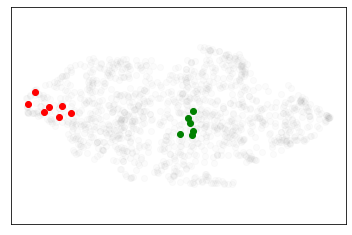

In [ ]:
# UMAP Representations of Semantic Frame Embeddings
reducer = umap.UMAP(random_state=2020)
umap_embedding = reducer.fit_transform(out.cpu().detach().numpy())

# plot the graph
fig, ax = plt.subplots()
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    color='grey',
    alpha=0.03,
)

# commerce
commerce_fn_labels = [
    'Commerce_buy', 
    'Commerce_sell', 
    'Commerce_goods-transfer', 
    'Commerce_scenario',
    'Price_per_unit',
    'Renting_out',
    'Shopping'
]
commerce_IDs = list()
for fn_label in commerce_fn_labels:
    f = fn.frames(fn_label)[0]
    print(f.name, f.ID)
    commerce_IDs.append(f.ID)
    
for i, ID in enumerate(commerce_IDs):
    idx = nodes_to_x[ID]
    ax.scatter(umap_embedding[:, 0][idx], umap_embedding[:, 1][idx], color='red')
    # if commerce_IDs[i] == 1729:
    #     ax.annotate(commerce_IDs[i], xy = (umap_embedding[:, 0][idx], umap_embedding[:, 1][idx]), textcoords='data')

# vocation
vocation_fn_labels = [
    'People_by_vocation',
    'Becoming_a_member',
    'Being_employed',
    'Employee_scenario',
    'Member_of_military',
    'Medical_professionals',
]
vocation_IDs = list()
for fn_label in vocation_fn_labels:
    f = fn.frames(fn_label)[0]
    print(f.name, f.ID)
    vocation_IDs.append(f.ID)
    
for i, ID in enumerate(vocation_IDs):
    idx = nodes_to_x[ID]
    ax.scatter(umap_embedding[:, 0][idx], umap_embedding[:, 1][idx], color='green')
    # if vocation_IDs[i] == 1733:
    #     ax.annotate(vocation_IDs[i], xy = (umap_embedding[:, 0][idx], umap_embedding[:, 1][idx]), textcoords='data')

ax.set_aspect('equal', 'datalim')
ax.set_facecolor('white')
ax.set_xticks([])
ax.set_yticks([])
fig.show()